# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

__Описание данных__

__Признаки__

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

__Целевой признак__

Price — цена (евро)

## Подготовка данных

### Загрузка библиотек

In [1]:
!pip3 install catboost

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import time
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from math import sqrt


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import GridSearchCV

import catboost as ctb

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

и глобальных переменных с настройками:

In [3]:
RANDOM_STATE = 42

pd.set_option('display.max_rows', 500)

### Загрузка файла

In [4]:
# Загрузка данных
url_local = 'datasets/autos.csv'
url_global = 'https://code.s3.yandex.net/datasets/autos.csv'

if os.path.exists(url_local):
    data = pd.read_csv(url_local, sep = ',')
elif os.path.exists(url_global):
    data = pd.read_csv(url_global, sep = ',')
else:
    print('OMG! Something is wrong.')

Проверим, что загрузилось

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Посмотрим общую информацию о data:

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Проверим типы данных

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Посмотрим пропуски в датасете

In [8]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

удалим дубликаты, если они есть

In [9]:
data = data.drop_duplicates().reset_index(drop=True)

# посмотрим новый размер
data.shape

(354365, 16)

По анализу общей информации и типов данных видно, что:
    
* имеются пропуски. Если эти признаки будут сохранены, то необходимо будет их восполнить.
* типы данных не соответствуют необходимым и есть категориальные признаки
* Имеются аномалии. Например, минимальная цена (Price) равна нулю.


Необхоимо произвести Разведочный анализ данных, в тч по каждому признаку.

### Разведочный анализ данных

#### DateCrawled — дата скачивания анкеты из базы 

Посмотрим на данные

In [10]:
data.DateCrawled[:5]

0    2016-03-24 11:52:17
1    2016-03-24 10:58:45
2    2016-03-14 12:52:21
3    2016-03-17 16:54:04
4    2016-03-31 17:25:20
Name: DateCrawled, dtype: object

Посмотрим уникальные дни оценки автомобилей:

In [11]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['DateCrawled'] = pd.to_datetime(data['DateCrawled']).dt.strftime('%Y-%m-%d')
data['DateCrawled'].unique()

array(['2016-03-24', '2016-03-14', '2016-03-17', '2016-03-31',
       '2016-04-04', '2016-04-01', '2016-03-21', '2016-03-26',
       '2016-04-07', '2016-03-15', '2016-03-11', '2016-03-20',
       '2016-03-23', '2016-03-27', '2016-03-12', '2016-03-13',
       '2016-03-18', '2016-03-10', '2016-03-07', '2016-03-09',
       '2016-03-08', '2016-04-03', '2016-03-29', '2016-03-25',
       '2016-03-28', '2016-03-30', '2016-03-22', '2016-03-05',
       '2016-04-02', '2016-03-16', '2016-03-19', '2016-04-05',
       '2016-03-06', '2016-04-06'], dtype=object)

По датам видно, что анкетные данные были были за уже далекий март-апрель 2016 года.
Какие-либо действия в данным полем производить бессмысленно. Не будет использоваться в дальнешем.

#### Price - целевая функция

Как ранее упомяналось, минимальная стоимость равна нулю. Необходимо более подробное изучение аномалий. Посмотрим частоту распределения поля Price на гистограмме.

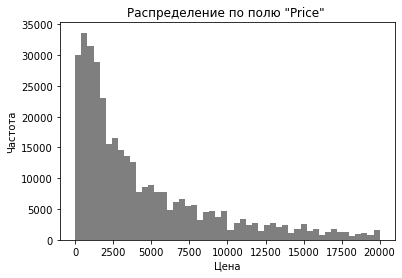

In [12]:
data.Price.plot(kind="hist",
                      title='Распределение по полю "Price" ',
                      color="k", 
                      alpha=0.5, 
                      bins=50)
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

и сразу на боксплоте:

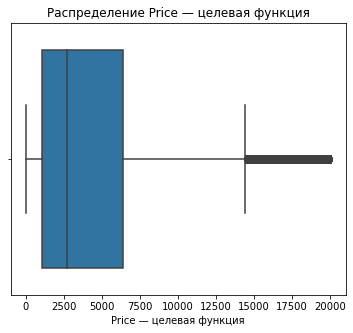

In [13]:
plt.figure(figsize=(6, 5));
ax=sns.boxplot(x = data.Price);
ax.set()

plt.xlabel("Price — целевая функция");
plt.title('Распределение Price — целевая функция')
plt.show();

Посмотрим точное количество значений строк со значением Price интервале принадлежащем [500, 14000]

In [14]:
print('Количество значений строк со значением Price интервале принадлежащем [500,14000]')
sum((data['Price']>500) & (data['Price']<14000))

Количество значений строк со значением Price интервале принадлежащем [500,14000]


292448

Если удалить, выбросы и аномолии (всю строку), то данные будет достаточно для построения моделей, в тч. бустинговых.
Удаляем...

In [15]:
print('data исходный :', data.shape)

data = data[(data['Price']>500) & (data['Price']<14000)]

print('data после удаления:', data.shape)

data исходный : (354365, 16)
data после удаления: (292448, 16)


#### VehicleType — тип автомобильного кузова

In [16]:
data.VehicleType.unique()

array(['suv', 'small', 'sedan', 'convertible', 'wagon', 'bus', 'coupe',
       nan, 'other'], dtype=object)

In [17]:
data.VehicleType.value_counts(dropna=False)

sedan          78657
small          65463
wagon          55867
bus            25779
NaN            25582
convertible    16963
coupe          12517
suv             9016
other           2604
Name: VehicleType, dtype: int64

Имеются пропуски (Nan). Заменим данные пропущенные значения полем о неизвестном типе кузова: 'unknow_VehicleType'

In [18]:
data.VehicleType = data.VehicleType.fillna('unknow_VehicleType');

# и проверим
print('Количество пропусков VehicleType (тип автомобильного кузова):', sum(data.VehicleType.isnull()))

Количество пропусков VehicleType (тип автомобильного кузова): 0


#### RegistrationYear — год регистрации автомобиля

In [19]:
data.RegistrationYear[:5]

2    2004
3    2001
4    2008
5    1995
6    2004
Name: RegistrationYear, dtype: int64

Посмотрим боксплот

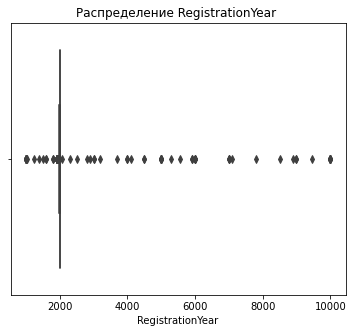

In [20]:
plt.figure(figsize=(6, 5));
ax=sns.boxplot(x = data.RegistrationYear);
ax.set()

plt.xlabel("RegistrationYear");
plt.title('Распределение RegistrationYear ')
plt.show();

Год регистрации автомобиля не может быть позднее года заполнения анкеты (RegistrationMonth) или 2016 года. Посмотрим еще частоту распределения.

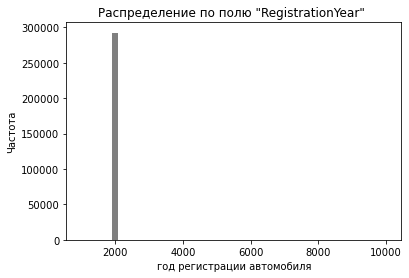

In [21]:
data.RegistrationYear.plot(kind="hist",
                      title='Распределение по полю "RegistrationYear" ',
                      color="k", alpha=0.5, bins=50, )
plt.xlabel('год регистрации автомобиля')
plt.ylabel('Частота')
plt.show()

Минимальное значение 1000 и максимальное 9999 тоже не годится. Данные значения встречаются не часто. Удалим их.

In [22]:
# Удалим записи, в которых дата заполнения более 2016 года.
print('data до удаления', data.shape)

data = data[data['RegistrationYear'] <= 2016]

print('data после удаления', data.shape)

data до удаления (292448, 16)
data после удаления (279949, 16)


Посмотрим минимальное значение

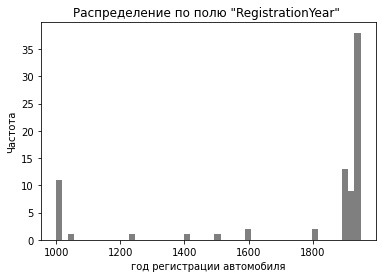

In [23]:
data.RegistrationYear[data.RegistrationYear<1950].plot(kind="hist",
                      title='Распределение по полю "RegistrationYear" ',
                      color="k", alpha=0.5, bins=50, )
plt.xlabel('год регистрации автомобиля')
plt.ylabel('Частота')
plt.show()

Значения по году выпуска автомобиля менее 1950 года незначительное количество. Удалим и эти значения.

In [24]:
# Удалим записи, в которых дата регистрации менее 1950 года.
print('data до удаления', data.shape)

data = data[data['RegistrationYear'] > 1950]

print('data после удаления', data.shape)

data до удаления (279949, 16)
data после удаления (279860, 16)


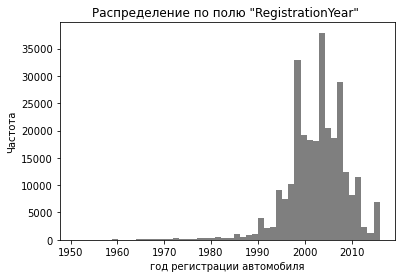

In [25]:
data.RegistrationYear.plot(kind="hist",
                      title='Распределение по полю "RegistrationYear" ',
                      color="k", alpha=0.5, bins=50, )
plt.xlabel('год регистрации автомобиля')
plt.ylabel('Частота')
plt.show()

#### Gearbox — тип коробки передач

Посмотрим на варианты типов коробки передач

In [26]:
data.Gearbox.unique()

array(['auto', 'manual', nan], dtype=object)

Скажем дружное "нет" Pie-plot:

In [27]:
data.Gearbox.value_counts(dropna = False)

manual    216530
auto       52282
NaN        11048
Name: Gearbox, dtype: int64

Действительно на АККП автомобилей до 2016 года при случайной выборке должно быть меньше, чем на МККП.

Но есть пропуски. Удалим эти значения.

In [28]:
# Удалим записи, в которых есть пропуски.
print('data до удаления', data.shape)

data = data[data.Gearbox.notnull()]

print('data после удаления', data.shape)

data до удаления (279860, 16)
data после удаления (268812, 16)


Сделаем ручной OHE, учитывая бинарную классификацию и заменим тип данных.

In [29]:
# Сделаем ручной OHE
data.loc[data.Gearbox == 'auto', 'Gearbox'] = 1
data.loc[data.Gearbox != 1, 'Gearbox'] = 0

# Заменим тип данных
data.Gearbox = data.Gearbox.astype('int64');

# Проверим, что получилось
data.Gearbox.value_counts(dropna=False)

0    216530
1     52282
Name: Gearbox, dtype: int64

#### Power — мощность (л. с.)

Посмотрим частоту распределения

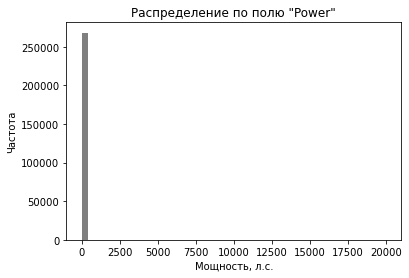

In [30]:
data.Power.plot(kind="hist",
                      title='Распределение по полю "Power"',
                      color="k", alpha=0.5, bins=50,  )
plt.xlabel('Мощность, л.с.')
plt.ylabel('Частота')
plt.show()

и бокс-плот

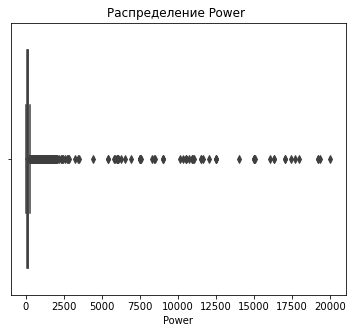

In [31]:
plt.figure(figsize=(6, 5));
ax=sns.boxplot(x = data.Power);
ax.set()

plt.xlabel("Power");
plt.title('Распределение Power ')
plt.show();

Посмотрим распределение по автомобилям, которые имеют мощность менее 300 лс:

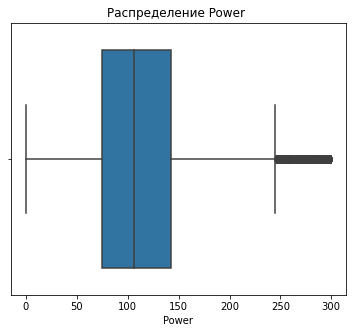

In [32]:
plt.figure(figsize=(6, 5));
ax=sns.boxplot(x = data[data.Power<300]['Power']);
ax.set()

plt.xlabel("Power");
plt.title('Распределение Power ')
plt.show();

Удалим записи, в которых есть выбросы и аномально высокая мощность двигателя (более 300 л. с.).

In [33]:
print('data до удаления', data.shape)

data = data[data.Power<300]

print('data после удаления', data.shape)

data до удаления (268812, 16)
data после удаления (266638, 16)


И аномально маловероятные малолитражки, в которых менее 75 л. с. тоже удалим:

In [34]:
print('data до удаления', data.shape)

data = data[data.Power>75]

print('data после удаления', data.shape)

data до удаления (266638, 16)
data после удаления (189708, 16)


#### Model — модель автомобиля

In [35]:
data.Model.unique()

array(['grand', '3er', '2_reihe', 'golf', '3_reihe', 'passat', 'c_max',
       'a_klasse', 'scirocco', '5er', 'civic', 'e_klasse', 'other', 'one',
       '1er', 'b_klasse', 'a8', 'jetta', 'c_klasse', 'micra', 'vito',
       'sprinter', 'forester', 'xc_reihe', 'fiesta', 'scenic',
       'transporter', 'focus', 'a4', 'tt', 'astra', 'a6', 'jazz', 'polo',
       'slk', '7er', '80', nan, '147', 'z_reihe', 'sorento', 'eos',
       'touran', 'getz', 'insignia', 'almera', 'megane', 'a3', 'mondeo',
       'cordoba', 'impreza', 'a1', 'vectra', 'clio', 'tiguan', '6_reihe',
       'c4', 'i_reihe', 'ceed', 'yeti', 'fabia', 'octavia', 'zafira',
       'rx_reihe', 'corsa', 'beetle', 'rio', 'ibiza', 'spider', 'omega',
       's_max', 'modus', 'c3', 'panda', 'sharan', 'avensis', 'viano',
       'sl', 'santa', 'leon', 'cooper', '4_reihe', 'sportage', 'caddy',
       'laguna', 'ptcruiser', 'clk', 'primera', 'espace', 's_klasse',
       'galaxy', '159', 'transit', 'juke', 'x_reihe', 'v40', 'carisma',
    

заменим other на other_Model

In [36]:
data.Model = data.Model.replace('other', 'other_Model');
data.Model.unique()

array(['grand', '3er', '2_reihe', 'golf', '3_reihe', 'passat', 'c_max',
       'a_klasse', 'scirocco', '5er', 'civic', 'e_klasse', 'other_Model',
       'one', '1er', 'b_klasse', 'a8', 'jetta', 'c_klasse', 'micra',
       'vito', 'sprinter', 'forester', 'xc_reihe', 'fiesta', 'scenic',
       'transporter', 'focus', 'a4', 'tt', 'astra', 'a6', 'jazz', 'polo',
       'slk', '7er', '80', nan, '147', 'z_reihe', 'sorento', 'eos',
       'touran', 'getz', 'insignia', 'almera', 'megane', 'a3', 'mondeo',
       'cordoba', 'impreza', 'a1', 'vectra', 'clio', 'tiguan', '6_reihe',
       'c4', 'i_reihe', 'ceed', 'yeti', 'fabia', 'octavia', 'zafira',
       'rx_reihe', 'corsa', 'beetle', 'rio', 'ibiza', 'spider', 'omega',
       's_max', 'modus', 'c3', 'panda', 'sharan', 'avensis', 'viano',
       'sl', 'santa', 'leon', 'cooper', '4_reihe', 'sportage', 'caddy',
       'laguna', 'ptcruiser', 'clk', 'primera', 'espace', 's_klasse',
       'galaxy', '159', 'transit', 'juke', 'x_reihe', 'v40', 'carisma'

Посмотрим пропуски

In [37]:
sum(data.Model.isnull())

6038

Заменим эти значения на значение 'unknow'

In [38]:
data.Model = data.Model.fillna('unknow_model')

# проверим, что получилось
sum(data.Model.isnull())

0

#### Kilometer — пробег (км)

Посмотрим бокс-плот

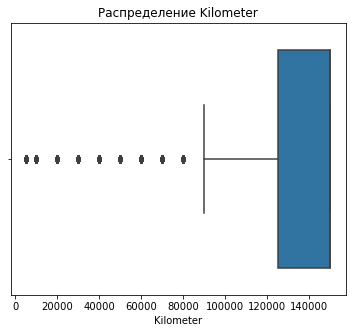

In [39]:
plt.figure(figsize=(6, 5));
ax=sns.boxplot(x = data.Kilometer);
ax.set()

plt.xlabel("Kilometer");
plt.title('Распределение Kilometer')
plt.show();

Удалим записи, в которых машины имеют пробег менее 90 тыс. км.

In [40]:
print('data до удаления', data.shape)

data = data[data.Kilometer > 90000]

print('data после удаления', data.shape)

data до удаления (189708, 16)
data после удаления (162122, 16)


#### RegistrationMonth — месяц регистрации автомобиля

Данный показатель не должен влиять на стоимость автомобиля. Не будем его использовать.

#### FuelType — тип топлива

In [41]:
data.FuelType.unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [42]:
data.FuelType = data.FuelType.replace('other', 'other_FuelType')

In [43]:
sum(data.FuelType.isnull())

7135

In [44]:
data.FuelType = data.FuelType.fillna('unknow_Fuel')

# проверим, что получилось
sum(data.FuelType.isnull())

0

#### Brand — марка автомобиля

In [45]:
data.Brand.unique()

array(['jeep', 'bmw', 'peugeot', 'volkswagen', 'mazda', 'ford',
       'mercedes_benz', 'mini', 'audi', 'honda', 'subaru', 'volvo',
       'mitsubishi', 'renault', 'opel', 'alfa_romeo', 'hyundai', 'nissan',
       'seat', 'lancia', 'citroen', 'toyota', 'kia', 'skoda', 'suzuki',
       'fiat', 'chrysler', 'sonstige_autos', 'jaguar', 'daewoo', 'rover',
       'porsche', 'smart', 'saab', 'chevrolet', 'dacia', 'land_rover',
       'lada', 'daihatsu'], dtype=object)

О! Здесь есть лада! Интересно какая?
Седан-баклажан, Калина-спорт, или легандарная вишневая девятка? :) 

А какая разница, если в столбце нет значений Nan =]

#### Repaired — была машина в ремонте или нет

Посмотрим количество значений

In [46]:
data.Repaired.value_counts(dropna=False)

no     125885
NaN     21451
yes     14786
Name: Repaired, dtype: int64

По умолчанию машина "не бита, не крашена". Поэтому пропуски заменим дефолтным значением No. Признак бинарный. Поэтому сделаем "ручной" ОНЕ.

In [47]:
data.loc[data.Repaired == 'yes', 'Repaired'] = 1
data.loc[data.Repaired != 1, 'Repaired'] = 0

# Заменим тип данных
data.Repaired = data.Repaired.astype('int64');

# Проверим, что получилось
data.Repaired.value_counts(dropna=False)

0    147336
1     14786
Name: Repaired, dtype: int64

#### DateCreated — дата создания анкеты

In [48]:
data.DateCreated.unique()

array(['2016-03-14 00:00:00', '2016-04-04 00:00:00',
       '2016-04-01 00:00:00', '2016-03-17 00:00:00',
       '2016-03-26 00:00:00', '2016-04-07 00:00:00',
       '2016-03-15 00:00:00', '2016-03-21 00:00:00',
       '2016-03-23 00:00:00', '2016-03-27 00:00:00',
       '2016-03-18 00:00:00', '2016-04-03 00:00:00',
       '2016-03-13 00:00:00', '2016-03-29 00:00:00',
       '2016-03-31 00:00:00', '2016-03-25 00:00:00',
       '2016-03-08 00:00:00', '2016-02-09 00:00:00',
       '2016-03-07 00:00:00', '2016-03-22 00:00:00',
       '2016-03-11 00:00:00', '2016-03-10 00:00:00',
       '2016-03-12 00:00:00', '2016-04-02 00:00:00',
       '2016-03-16 00:00:00', '2016-03-20 00:00:00',
       '2016-03-09 00:00:00', '2016-03-24 00:00:00',
       '2016-03-28 00:00:00', '2016-04-05 00:00:00',
       '2016-03-19 00:00:00', '2016-03-06 00:00:00',
       '2016-03-05 00:00:00', '2016-03-30 00:00:00',
       '2016-03-03 00:00:00', '2016-03-01 00:00:00',
       '2016-04-06 00:00:00', '2016-03-04 00:0

Предиктивной способности у данного признака нет. Не будем использовать в дальнешем.

#### NumberOfPictures — количество фотографий автомобиля

In [49]:
data.NumberOfPictures.value_counts()

0    162122
Name: NumberOfPictures, dtype: int64

Предиктивной способности у данного признака нет. Не будем использовать в дальнешем.

#### PostalCode — почтовый индекс владельца анкеты (пользователя)

In [50]:
data.PostalCode.unique()

array([90480, 33775, 67112, ..., 97259, 29491, 95691], dtype=int64)

По данному признаки возможно определить географию и использовать в качестве признака. Но... "не сегодня".

Не будем использовать в дальнешем.

#### LastSeen — дата последней активности пользователя

In [51]:
data.LastSeen.unique()

array(['2016-04-05 12:47:46', '2016-04-06 19:17:07',
       '2016-04-05 18:18:39', ..., '2016-04-02 18:16:20',
       '2016-03-13 01:44:13', '2016-03-19 20:44:43'], dtype=object)

Отсутствует предиктивная способность.

#### Создание итогового датасета


Выберем поля, которые оказывают влияние на стоимость автомобиля (price), и сформируем итоговый дата-сет.

In [52]:
columns_for_predict = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired', 'Price']
data = data[columns_for_predict]
data.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Price
2,suv,2004,1,163,grand,125000,gasoline,jeep,0,9800
5,sedan,1995,0,102,3er,150000,petrol,bmw,1,650
6,convertible,2004,0,109,2_reihe,150000,petrol,peugeot,0,2200
9,small,1998,0,101,golf,150000,unknow_Fuel,volkswagen,0,999
10,sedan,2004,0,105,3_reihe,150000,petrol,mazda,0,2000


Проверим тип данных еще раз.

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162122 entries, 2 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       162122 non-null  object
 1   RegistrationYear  162122 non-null  int64 
 2   Gearbox           162122 non-null  int64 
 3   Power             162122 non-null  int64 
 4   Model             162122 non-null  object
 5   Kilometer         162122 non-null  int64 
 6   FuelType          162122 non-null  object
 7   Brand             162122 non-null  object
 8   Repaired          162122 non-null  int64 
 9   Price             162122 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 13.6+ MB


In [54]:
#КОД РЕВЬЮЕРА

data.describe()

,RegistrationYear,Gearbox,Power,Kilometer,Repaired,Price
count,162122.000000,162122.000000,162122.000000,162122.000000,162122.000000,162122.000000
mean,2002.496231,0.231801,137.103052,144779.702940,0.091203,4430.443203
std,5.360605,0.421984,40.445465,12703.717637,0.287898,3272.008608
min,1955.000000,0.000000,76.000000,100000.000000,0.000000,501.000000
25%,1999.000000,0.000000,105.000000,150000.000000,0.000000,1800.000000
50%,2003.000000,0.000000,131.000000,150000.000000,0.000000,3500.000000
75%,2006.000000,0.000000,160.000000,150000.000000,0.000000,6400.000000
max,2016.000000,1.000000,299.000000,150000.000000,1.000000,13999.000000


## Обучение моделей

Разделение на категориальные и числовые признаки:

In [55]:
features_categorical = ['VehicleType', 'Model', 'FuelType', 'Brand']
features_quant = ['RegistrationYear', 'Gearbox', 'Power', 'Kilometer', 'Repaired']

In [56]:
X = data.drop(['Price'], axis=1)
y = data['Price']

In [57]:
# разделим датасет на тестовую и обучающую выборки
features_train, features_test, target_train, target_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE)

# проверим, что получилось:
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((129697, 9), (32425, 9), (129697,), (32425,))

Сделаем порядковое кодирование

In [58]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', dtype='int', unknown_value=-1)

features_train_oe = features_train.copy()
features_test_oe = features_test.copy()

features_train_oe[features_categorical] = encoder.fit_transform(features_train[features_categorical])
features_test_oe[features_categorical] = encoder.transform(features_test[features_categorical])

In [59]:
features_train_oe = features_train_oe.astype('int64');

Сделаем прямое кодирование

In [60]:
X_train_LM = features_train.copy()
X_test_LM = target_train.copy()

In [61]:
encoder_ohe = OneHotEncoder(drop='first', sparse=False)

In [62]:
# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(X_train_LM[features_categorical])

OneHotEncoder(drop='first', sparse=False)

In [63]:
encoder_ohe.transform(features_train[features_categorical])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [64]:
# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
X_train_LM[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_train_LM[features_categorical])

C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_LM[
C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_LM[
C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_LM[
C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_LM[
C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_LM[
C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_LM[
C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_LM[
C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_LM[
C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_LM[
C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_LM[
C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_LM[
C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_LM[
C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_LM[
C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_LM[
C:\Users\izara\AppData\Local\Temp\ipykernel_18356\739164516.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

In [65]:
# удаляем незакодированные категориальные признаки (изначальные колонки)
X_train_LM = X_train_LM.drop(features_categorical, axis=1)

In [66]:
# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
X_train_LM[features_quant] = scaler.fit_transform(X_train_LM[features_quant])

# смотрим на результат
X_train_LM.head()

,RegistrationYear,Gearbox,Power,Kilometer,Repaired,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_volkswagen,Brand_volvo
329429,1.025010,-0.549066,-0.523584,0.410892,-0.317088,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13248,0.093503,-0.549066,-0.523584,0.410892,-0.317088,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58178,-0.465401,-0.549066,-1.413121,0.410892,-0.317088,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
343762,-0.465401,1.821276,0.810723,0.410892,-0.317088,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302191,-0.465401,-0.549066,0.192989,0.410892,3.153699,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# Таблица результатов
model_rep = pd.DataFrame({"Model": [],
                          "fit time, sec": [],
                          "predict time, sec": [],
                          "RMSE": []
                          })
model_rep

,Model,"fit time, sec","predict time, sec",RMSE


### Линейная модель

In [68]:
LM = LinearRegression()
params = {'fit_intercept':[True, False]}
clf = GridSearchCV(LM, params, cv = 3, scoring='neg_root_mean_squared_error', n_jobs=-1)
clf.fit(X_train_LM, target_train);

In [69]:
result_ML = pd.DataFrame(clf.cv_results_)
result_ML

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,23.568857,2.709676,0.284704,0.148773,True,{'fit_intercept': True},-1980.656989,-1999.740511,-2011.505190,-1997.300897,12.711325,1
1,10.913230,7.772552,0.151571,0.100155,False,{'fit_intercept': False},-1983.682057,-2001.640092,-2013.582339,-1999.634829,12.288817,2


In [70]:
model_rep = model_rep.append({"Model": 'Line Model',
                          "fit time, sec": result_ML[result_ML['rank_test_score']==1]['mean_fit_time'].values[0],
                          "predict time, sec": result_ML[result_ML['rank_test_score']==1]['mean_score_time'].values[0],
                          "RMSE": round((clf.best_score_ * -1)**0.5, 2)
                          },
                         ignore_index=True)
model_rep

C:\Users\izara\AppData\Local\Temp\ipykernel_18356\2349969958.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_rep = model_rep.append({"Model": 'Line Model',


,Model,"fit time, sec","predict time, sec",RMSE
0,Line Model,23.568857,0.284704,44.69


### CatBoostRegressor

In [71]:
%%time
model_CBR = ctb.CatBoostRegressor(iterations = 100,
                                  random_state=RANDOM_STATE, 
                                  verbose=False, 
                                 cat_features = features_categorical)

params = [{'learning_rate':[0.1, 0.5, 0.8]}]
clf = GridSearchCV(model_CBR, params,
                   cv=3,
                   scoring='neg_mean_squared_error')
clf.fit(features_train, target_train);

CPU times: total: 1min 6s
Wall time: 1min 4s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000002394C32C760>,
             param_grid=[{'learning_rate': [0.1, 0.5, 0.8]}],
             scoring='neg_mean_squared_error')

In [72]:
result_CBR = pd.DataFrame(clf.cv_results_)
result_CBR

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,6.644301,0.755887,0.086168,0.001542,0.1,{'learning_rate': 0.1},-2.219956e+06,-2.231702e+06,-2.258689e+06,-2.236782e+06,16215.394248,3
1,5.983351,0.153204,0.089681,0.004986,0.5,{'learning_rate': 0.5},-2.015138e+06,-2.020421e+06,-2.031416e+06,-2.022325e+06,6780.446126,1
2,5.826674,0.039094,0.090013,0.005578,0.8,{'learning_rate': 0.8},-2.021976e+06,-2.026655e+06,-2.047004e+06,-2.031878e+06,10864.868778,2


In [73]:
model_rep = model_rep.append({"Model": 'CatBoostRegressor',
                          "fit time, sec": result_CBR[result_CBR['rank_test_score']==1]['mean_fit_time'].values[0],
                          "predict time, sec": result_CBR[result_CBR['rank_test_score']==1]['mean_score_time'].values[0],
                          "RMSE": round((clf.best_score_ * -1)**0.5, 2)
                          },
                         ignore_index=True)
model_rep

C:\Users\izara\AppData\Local\Temp\ipykernel_18356\2382825269.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_rep = model_rep.append({"Model": 'CatBoostRegressor',


,Model,"fit time, sec","predict time, sec",RMSE
0,Line Model,23.568857,0.284704,44.69
1,CatBoostRegressor,5.983351,0.089681,1422.08


### LGBMRegressor

In [74]:
%%time
features_train_2 = features_train.copy()
features_train_2[features_categorical] = features_train[features_categorical].astype('category')

model_lgbm = LGBMRegressor(random_state=RANDOM_STATE) #, categorical_column=features_categorical)
params = [{'num_leaves':[11, 50], 
                'learning_rate':[0.3]
               }]

clf = GridSearchCV(model_lgbm, params, scoring='neg_mean_squared_error', cv = 3)
clf.fit(features_train_2, target_train);

CPU times: total: 8.97 s
Wall time: 4.47 s


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=42),
             param_grid=[{'learning_rate': [0.3], 'num_leaves': [11, 50]}],
             scoring='neg_mean_squared_error')

In [75]:
result_LGBM = pd.DataFrame(clf.cv_results_)
result_LGBM

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.387880,0.005377,0.091325,0.015312,0.3,11,"{'learning_rate': 0.3, 'num_leaves': 11}",-1.960879e+06,-1.953843e+06,-1.978322e+06,-1.964348e+06,10290.043268,2
1,0.558508,0.068374,0.114887,0.010063,0.3,50,"{'learning_rate': 0.3, 'num_leaves': 50}",-1.869471e+06,-1.851545e+06,-1.889018e+06,-1.870011e+06,15302.843974,1


In [76]:
model_rep = model_rep.append({"Model": 'LGBMRegressor',
                          "fit time, sec": result_LGBM[result_LGBM['rank_test_score']==1]['mean_fit_time'].values[0],
                          "predict time, sec": result_LGBM[result_LGBM['rank_test_score']==1]['mean_score_time'].values[0],
                          "RMSE": round((clf.best_score_ * -1)**0.5, 2)
                          },
                         ignore_index=True)
model_rep

C:\Users\izara\AppData\Local\Temp\ipykernel_18356\1821377337.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_rep = model_rep.append({"Model": 'LGBMRegressor',


,Model,"fit time, sec","predict time, sec",RMSE
0,Line Model,23.568857,0.284704,44.69
1,CatBoostRegressor,5.983351,0.089681,1422.08
2,LGBMRegressor,0.558508,0.114887,1367.48


__Выводы__
 
*   Самое долгое обучение в линейной модели. Долгое обучение связано с тем, что размер датасета увеличен за счет OHE. Самое быстрое обучение в LGBM Regressor, в котором использовался кодирование OE.
*   Время предсказания наименьшее у LGBMRegressor
*  Наибольшая предиктивная способность у LGBM Regressor-а. Эту модель и будем анализировать в дальнешем. В линейной модели был использован метод шкалирования, который сильно занизил сумму ошибок.

## Анализ моделей

In [77]:
# Наилучший гиперпараметр для LGBMRegressor 
best_param = result_LGBM[result_LGBM['rank_test_score']==1]['params'].values[0]
best_param

{'learning_rate': 0.3, 'num_leaves': 50}

In [78]:
features_test_2 = features_test.copy()
features_test_2[features_categorical] = features_test[features_categorical].astype('category')

model_lgbm = LGBMRegressor(random_state=RANDOM_STATE) # , params = best_param


In [79]:
model_lgbm.fit(features_train_2, target_train)

LGBMRegressor(random_state=42)

In [80]:
pred = model_lgbm.predict(features_test_2)

In [81]:
rms = round(sqrt(mean_squared_error(pred, target_test)),2)
print('Полученный PMSE на тестовой выборке:', rms)

Полученный PMSE на тестовой выборке: 1368.99


__Вывод__


*   В рамках работы было проанализированы три модели: ML, CatBoost, LGBM. Наилучшу предиктивную способность показала модель LGBM. Также время обучения после OE было минимальным (в районе нескольких секунд).
*   Данная работа выполнялась несколько недель на Яндексе и не была реализована по причине обработки несколько часов каждой модели с постоянными "вылетами" и ошибками. Продолжение последующих работ целесобразно выполнять в Google.

